# This is the minimum Working Example to compute a multiple scattering experiment in the Q-Phase 

In [10]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Sat Jun 10 19:53:32 2017

@author: Bene

This file creates a fwd-model for the TESCAN Q-PHASE under 
multiple-scattering. It is majorly derived from  "LEarning approach for optical tomography"
U. S. Kamilov, BIG, EPFL, 2014.
"""
# %load_ext autoreload
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
import scipy as scipy

# load own functions
import src.model as mus
import src.tf_helper as tf_helper
import src.tf_generate_object as tf_go
import src.data as data

import src.optimization.tf_regularizers as reg
import os
from datetime import datetime

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')


# Define some optimization parameters 

In [11]:
'''Define some stuff related to infrastructure'''
mytimestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
savepath = os.path.join('./Data/DROPLETS/RESULTS/', mytimestamp)

# Create directory
try: 
    os.mkdir(savepath)
except(FileExistsError): 
    print('Folder exists already')

is_display = True
is_optimization = True 

'''Define Optimization Parameters'''
my_learningrate = 1e-4  # learning rate
lambda_tv = 1e-3 # lambda for Total variation
lambda_gr = 0 # lambda for Goods Roughness 
lambda_pos = 10
lambda_neg = 10

Niter = 10000
Ndisplay = 10

In [12]:
tf.reset_default_graph()
is_display = False
''' File which stores the experimental parameters from the Q-PHASE setup 
    1.) Read in the parameters of the dataset ''' 
matlab_par_file = './Data/DROPLETS/myParameterNew.mat'   
matlab_pars = data.import_parameters_mat(filename = matlab_par_file, matname='myParameterNew')

''' 2.) Read in the parameters of the dataset ''' 
matlab_val_file = './Data/DROPLETS/allAmp_red.mat'   
matlab_val = data.import_realdata_h5(filename = matlab_val_file, matname='allAmp_red', is_complex=True)
np_meas = np.flip(matlab_val,0)

''' Create the Model'''
muscat = mus.MuScatModel(matlab_pars, is_optimization=is_optimization)
muscat.Nx,muscat.Ny = int(np.squeeze(matlab_pars['Nx'].value)), int(np.squeeze(matlab_pars['Ny'].value))
muscat.NAc = .3
#muscat.NAo = .4

Assigned some value for dn which is not good!


# Handle the COMA/decentered Lightsource?!

In [13]:
# INVERTING THE MISAGLINMENT OF THE SYSTEM! Its consered to be coma and/or shifted optical axis of the illumination in Y-direction!
muscat.shiftIcX = 0 # shifts pupil along X; >0 -> shifts down (influences YZ-Plot)
muscat.shiftIcY = 1 # shifts pupil along Y; >0 -> shifts right (influences XZ-Plot)
muscat.comaX = 0 # introduces Coma in X direction 
muscat.comaY = -2 # introduces Coma in X direction 
muscat.dn = .04
muscat.mysize = (muscat.Nz,muscat.Nx,muscat.Ny) # ordering is (Nillu, Nz, Nx, Ny)

# Generate Test-Object

In [14]:
''' Create a 3D Refractive Index Distributaton as a artificial sample'''
obj = tf_go.generateObject(mysize=muscat.mysize, obj_dim=muscat.dx, obj_type ='sphere', diameter = 2, dn = muscat.dn)

# Compute the System's properties (e.g. Pupil function/Illumination Source, K-vectors, etc.)

In [15]:
''' Compute the systems model'''
muscat.computesys(obj, is_zernike=True)

----------> Be aware: We are taking aberrations into account!
Shifting the illumination in X by: 0 Pixel
Shifting the illumination in Y by: 1 Pixel
Number of Illumination Angles / Plane waves: 21


# Generate Computational Graph (fwd model)

In [16]:
tf_fwd = muscat.computemodel()# Generate Test-Object

if(is_display): plt.subplot(121), plt.title('Ic'), plt.imshow(muscat.Ic), plt.subplot(122), plt.title('Po'),plt.imshow(np.fft.fftshift(np.angle(muscat.Po))), plt.colorbar(), plt.show()

Buildup Q-PHASE Model 


# Compute the fwd model with a guess-object and compare to real measurement

In [17]:
''' Evaluate the model '''
sess = tf.Session()
sess.run(tf.initialize_all_variables())
myres = sess.run(tf_fwd, feed_dict={muscat.TF_obj:obj})

## Compare Phase of measured and simulated data

(Text(0.5,1,'Experiment: XY'),
 <matplotlib.colorbar.Colorbar at 0x14665522b38>)

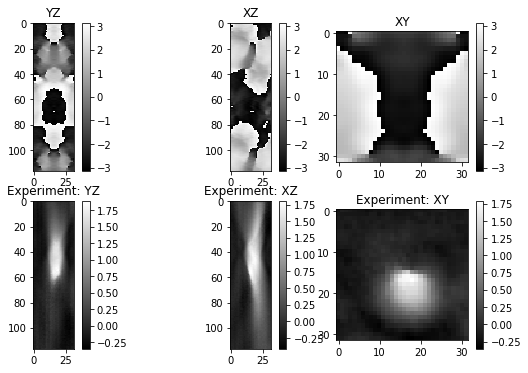

In [18]:
# add noise
myres_noise = myres + 0.001*np.random.randn(muscat.Nz,muscat.Nx,muscat.Ny)

plt.subplot(231)
plt.title('YZ'),plt.imshow(np.angle(myres_noise)[:,muscat.mysize[1]//2,:]), plt.colorbar()
plt.subplot(232)
plt.title('XZ'),plt.imshow(np.angle(myres_noise)[:,:,muscat.mysize[2]//2]), plt.colorbar()
plt.subplot(233)
plt.title('XY'),plt.imshow(np.angle(myres_noise)[muscat.mysize[0]//2,:,:]), plt.colorbar()

plt.subplot(234)
plt.title('Experiment: YZ'),plt.imshow(np.angle(matlab_val)[:,muscat.mysize[1]//2,:]), plt.colorbar()
plt.subplot(235)
plt.title('Experiment: XZ'),plt.imshow(np.angle(matlab_val)[:,:,muscat.mysize[2]//2]), plt.colorbar()
plt.subplot(236)
plt.title('Experiment: XY'),plt.imshow(np.angle(matlab_val)[muscat.mysize[0]//2,:,:]), plt.colorbar()
#data.save_timeseries(np.angle(matlab_val), 'droplet_meas_angle')
#data.save_timeseries(np.angle(myres), 'droplet_simu_angle')    

# Define Optimizer and Cost-function

Now load data which has been saved previously (Optional!)

In [19]:
#%%
'''Regression + Regularization'''
tf_meas = tf.placeholder(dtype=tf.complex64, shape=muscat.mysize)
             
'''Define Cost-function'''
tf_tvloss = lambda_tv*reg.tf_total_variation_regularization(muscat.TF_obj)  #Alernatively total_variation
tf_posloss = lambda_neg*reg.posiminity(muscat.TF_obj, minval=0)
tf_negloss = lambda_pos*reg.posimaxity(muscat.TF_obj, maxval=.2)  
tf_fidelity = tf.reduce_sum(tf_helper.tf_abssqr(tf_meas - tf_fwd))

tf_loss = tf_fidelity +  tf_negloss + tf_posloss + tf_tvloss

 # data fidelity
# TV regularization
# Positivity Penalty          
# eventually Goods Roughness reg
          
          
'''Define Optimizer'''
tf_optimizer = tf.train.AdamOptimizer(my_learningrate)
tf_lossop = tf_optimizer.minimize(tf_loss)


# this is the initial guess of the reconstruction
init_guess = np.angle(np_meas) - np.min(np.angle(np_meas))
init_guess = init_guess/np.max(init_guess)*muscat.dn

''' Evaluate the model '''
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.assign(muscat.TF_obj, init_guess)) # assign abs of measurement as initial guess of 


Regularizer: Penalize Values less then 0
Regularizer: Penalize Values higher then 0.2


array([[[0.00499782, 0.00555639, 0.00482298, ..., 0.00621157,
         0.00681505, 0.00608698],
        [0.00541144, 0.00523692, 0.00420978, ..., 0.00660047,
         0.00638703, 0.00580614],
        [0.00526946, 0.00412313, 0.00387921, ..., 0.00573607,
         0.00597928, 0.00619747],
        ...,
        [0.0056728 , 0.00595142, 0.00513601, ..., 0.01439318,
         0.0150177 , 0.01440697],
        [0.00521587, 0.00594277, 0.00510472, ..., 0.01494921,
         0.01472897, 0.01443134],
        [0.00473004, 0.00546719, 0.00500344, ..., 0.01430463,
         0.01312841, 0.01403875]],

       [[0.00528222, 0.00545491, 0.00506837, ..., 0.00661399,
         0.00633228, 0.00690077],
        [0.0057672 , 0.00532023, 0.00439774, ..., 0.006871  ,
         0.00561324, 0.00650912],
        [0.00508652, 0.00424483, 0.0039638 , ..., 0.00682787,
         0.00574735, 0.00607939],
        ...,
        [0.00493113, 0.00613379, 0.00496807, ..., 0.01391606,
         0.01425746, 0.013813  ],
        [0.0

# Optimize

Start optimizing
MY loss: @10: 36478.79 - Fidelity: 36287.043, Neg: 0.0, Pos: 0.0003523304, TV: 191.74803
MY loss: @20: 22875.17 - Fidelity: 22683.42, Neg: 0.0, Pos: 0.001456579, TV: 191.74805
MY loss: @30: 17541.672 - Fidelity: 17349.92, Neg: 0.0, Pos: 0.0035792869, TV: 191.74808
MY loss: @40: 15281.763 - Fidelity: 15090.008, Neg: 0.0, Pos: 0.0067652566, TV: 191.74811
MY loss: @50: 14178.929 - Fidelity: 13987.17, Neg: 0.0, Pos: 0.01056049, TV: 191.74814
MY loss: @60: 13547.766 - Fidelity: 13356.003, Neg: 0.0, Pos: 0.014775624, TV: 191.74815
MY loss: @70: 13135.121 - Fidelity: 12943.354, Neg: 0.0, Pos: 0.019672029, TV: 191.74817
MY loss: @80: 12836.393 - Fidelity: 12644.619, Neg: 0.0, Pos: 0.025167828, TV: 191.74817
MY loss: @90: 12603.496 - Fidelity: 12411.717, Neg: 0.0, Pos: 0.03155744, TV: 191.7482
MY loss: @100: 12412.5625 - Fidelity: 12220.775, Neg: 0.0, Pos: 0.039025724, TV: 191.7482
MY loss: @110: 12250.857 - Fidelity: 12059.062, Neg: 0.0, Pos: 0.047624145, TV: 191.74823
MY loss

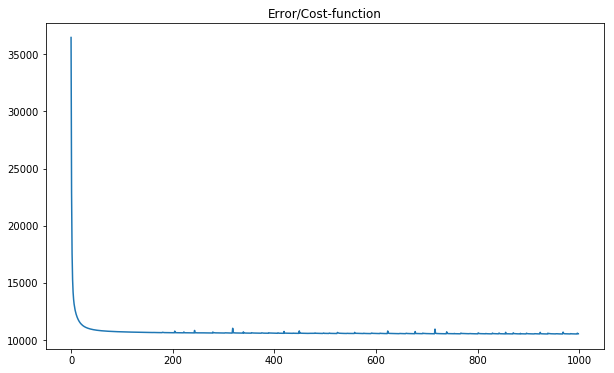

(Text(0.5,1,'Error/Cost-function'),
 None)

In [21]:
#%%
''' Optimize the model '''
print('Start optimizing')
mylosslist = []
for iterx in range(1,Niter):
    # try to optimize
    
    if(not np.mod(iterx, Ndisplay)):
        my_opt, my_res, my_loss, my_fidelity, my_negloss, my_posloss, my_tvloss =  \
            sess.run([tf_lossop, muscat.TF_obj, tf_loss, tf_fidelity, tf_negloss, tf_posloss, tf_tvloss], feed_dict={tf_meas:np_meas})
        
        #data.save_as_tif(np.squeeze(np.abs(my_res[:,muscat.mysize[1]//2,:])), 'res_xz', savepath)
        #data.save_as_tif(np.squeeze(np.abs(my_res[:,:,muscat.mysize[2]//2])), 'res_yz', savepath)
        #data.save_as_tif(np.squeeze(np.abs(my_res[muscat.mysize[0]//2,:,:])), 'res_xy', savepath)

        print('MY loss: @'+str(iterx)+': ' + str(my_loss) + ' - Fidelity: '+str(my_fidelity)+', Neg: '+str(my_negloss)+', Pos: '+str(my_posloss)+', TV: '+str(my_tvloss))        
        mylosslist.append(my_loss)
    else:
        sess.run([tf_lossop], feed_dict={tf_meas:np_meas})
        #plt.imshow(np.abs(my_res[:,50,:]))
        
# diplay the error over time
plt.title('Error/Cost-function'), plt.plot(np.array(mylosslist)), plt.show()


# Display result

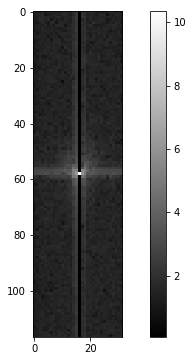

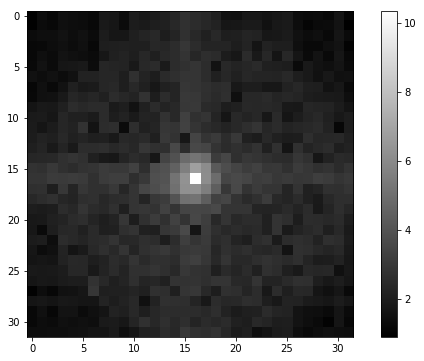

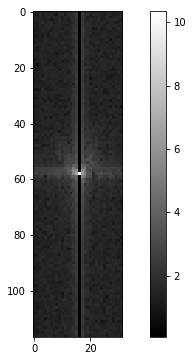

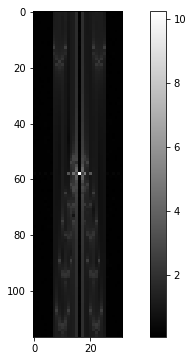

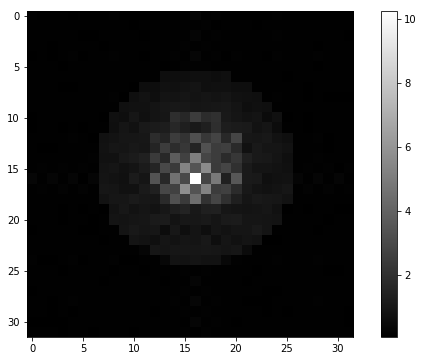

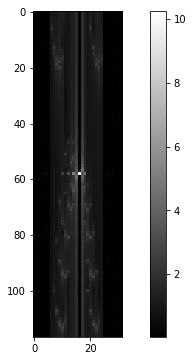

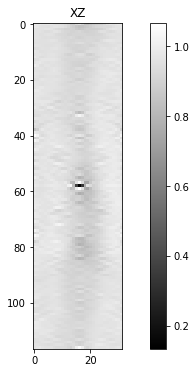

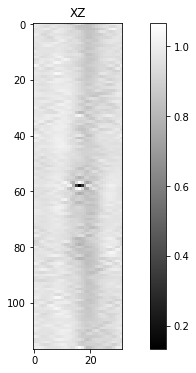

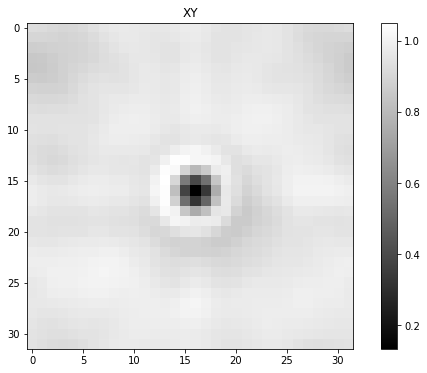

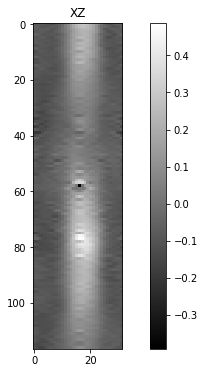

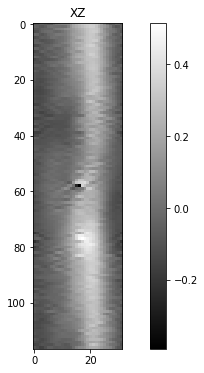

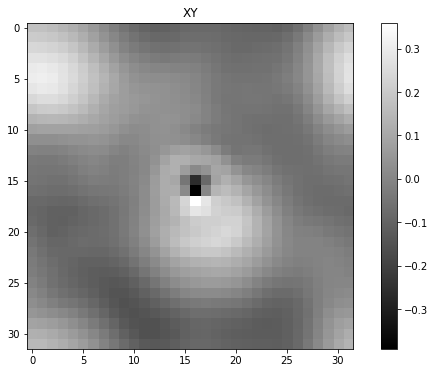

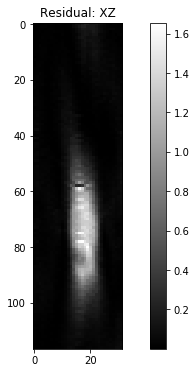

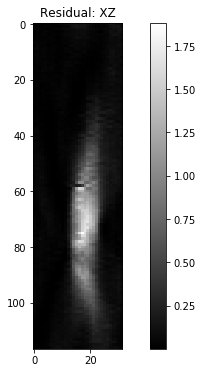

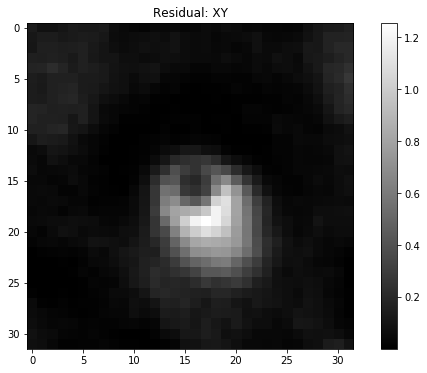

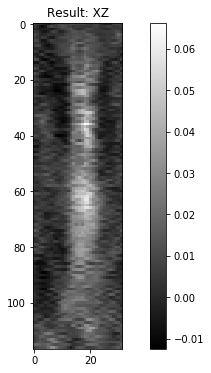

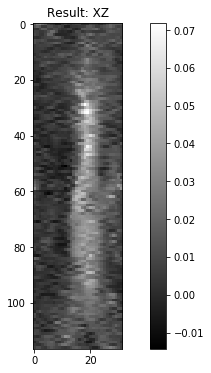

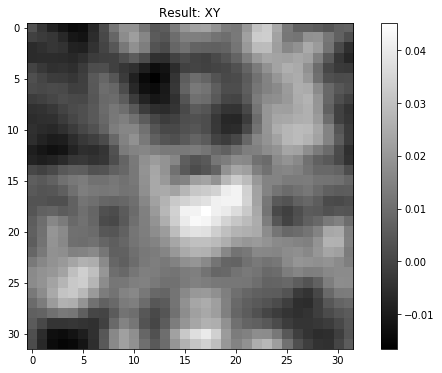

In [23]:
#%% Display the results
is_display=True
myfwd, mymeas, my_res = sess.run([tf_fwd, tf_meas, muscat.TF_obj], feed_dict={tf_meas:np_meas})
        
if(is_display): plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(mymeas))**.2)[:,muscat.mysize[1]//2,:]), plt.colorbar(), plt.show()    
if(is_display): plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(mymeas))**.2)[muscat.mysize[0]//2,:,:]), plt.colorbar(), plt.show()   
if(is_display): plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(mymeas))**.2)[:,:,muscat.mysize[2]//2]), plt.colorbar(), plt.show()     
if(is_display): plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))**.2)[:,muscat.mysize[1]//2,:]), plt.colorbar(), plt.show()
if(is_display): plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))**.2)[muscat.mysize[0]//2,:,:]), plt.colorbar(), plt.show()    
if(is_display): plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))**.2)[:,:,muscat.mysize[2]//2]), plt.colorbar(), plt.show()    
tf_helper.saveHDF5(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))), 'FFT3D_FWD')

if(is_display): plt.title('XZ'),plt.imshow(np.abs(myfwd)[:,muscat.mysize[1]//2,:]), plt.colorbar(), plt.show()
if(is_display): plt.title('XZ'),plt.imshow(np.abs(myfwd)[:,:,muscat.mysize[2]//2]), plt.colorbar(), plt.show()
if(is_display): plt.title('XY'),plt.imshow(np.abs(myfwd)[muscat.mysize[0]//2,:,:]), plt.colorbar(), plt.show()

if(is_display): plt.title('XZ'),plt.imshow(np.angle(myfwd)[:,muscat.mysize[1]//2,:]), plt.colorbar(), plt.show()
if(is_display): plt.title('XZ'),plt.imshow(np.angle(myfwd)[:,:,muscat.mysize[2]//2]), plt.colorbar(), plt.show()
if(is_display): plt.title('XY'),plt.imshow(np.angle(myfwd)[muscat.mysize[0]//2,:,:]), plt.colorbar(), plt.show()


my_residual = tf_helper.abssqr(myfwd-mymeas)
if(is_display): plt.title('Residual: XZ'),plt.imshow(my_residual [:,muscat.mysize[1]//2,:]), plt.colorbar(), plt.show()
if(is_display): plt.title('Residual: XZ'),plt.imshow(my_residual [:,:,muscat.mysize[2]//2]), plt.colorbar(), plt.show()
if(is_display): plt.title('Residual: XY'),plt.imshow(my_residual [muscat.mysize[0]//2,:,:]), plt.colorbar(), plt.show()


if(is_display): plt.title('Result: XZ'),plt.imshow(my_res[:,muscat.mysize[1]//2,:]), plt.colorbar(), plt.show()
if(is_display): plt.title('Result: XZ'),plt.imshow(my_res[:,:,muscat.mysize[2]//2]), plt.colorbar(), plt.show()
if(is_display): plt.title('Result: XY'),plt.imshow(my_res[muscat.mysize[0]//2,:,:]), plt.colorbar(), plt.show()


#%% save the results
np.save(savepath+'/rec.npy', my_res)
 
tf_helper.saveHDF5(my_res, savepath+'Obj_Reconstruction')
#tf_helper.saveHDF5(np_obj, savepath+'Obj_Orig')
tf_helper.saveHDF5(np.abs(np_meas), savepath+'Amplitude_abs')
tf_helper.saveHDF5(np.angle(np_meas), savepath+'Amplitude_angle')

# Save results

In [25]:
#%% save the results
np.save(savepath+'/rec.npy', my_res)
 
tf_helper.saveHDF5(my_res, savepath+'/Obj_Reconstruction.h5')
tf_helper.saveHDF5(np.abs(np_meas), savepath+'/Amplitude_abs.h5')
tf_helper.saveHDF5(np.angle(np_meas), savepath+'/Amplitude_angle.h5')